## Introduction:

Goal: Predict NFL player position group based on Madden ratings & physical data.

Main question: Given a player’s ratings (speed, strength, awareness, etc.) and physicals (height, weight), can we correctly classify what position group they play?

## Introducing the data

Source: https://mymadden.com/lg/mva26/export

Dataset contains: player info, player ratings (height, weight, speed, strength, awareness, blocking, coverage, throwing, etc.), contracts, traits, etc.

Features used:

Physical measures: height, weight

Ratings: speedRating, strengthRating, tackleRating, throwPowerRating, etc.

Target variable: player position (Broader positions grouped into categories such as OL, LB, EDGE, S, etc.)

## Pre-processing

Dropped irrelevant features (contracts, draft details, traits).

Grouped detailed positions into broader categories (e.g., LT/LG/C/RG/RT = OL, FS/SS = S).

Selected numeric ratings and physical features only.

Train/test split for evaluation.

## Visualization

Showed unique positions and counts (class distribution).

Visualized feature distributions (ex: height/weight differ strongly by position).
Helps confirm which features will help classification.

## Modeling

Random Forest Classifier.

Why:

Handles many features well, works without scaling, easy to interpret with feature importance, possible additional models.

## Evaluation

Metrics: Accuracy, Classification Report (Precision, Recall, F1-score).

Stratified train/test split to avoid imbalance bias.

Example results:

Accuracy ~94%.

Strong performance on OL/QB/DT, as these positions are typically rather distinct. For example, only quarterbacks have high throw power and throw accuracy stats.


## Conclusion

We learned Madden ratings contain enough signal to classify positions with decent accuracy.

Some overlaps (LB vs EDGE, S vs CB) make it difficult for the model to distinguish between them.

Side note:
Ratings are subjective, so using them to “classify” real players could be misleading.


## Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
df = pd.read_csv('/Users/tylerweber/ITSC3162/Project 2/players.csv')

In [3]:
df.columns.tolist()

['rosterId',
 'firstName',
 'lastName',
 'age',
 'height',
 'weight',
 'portraitId',
 'pos',
 'jerseyNum',
 'college',
 'yearsPro',
 'draftPick',
 'draftRound',
 'rookieYear',
 'dev',
 'experiencePoints',
 'skillPoints',
 'legacyScore',
 'capHit',
 'capReleaseNetSavings',
 'capReleasePenalty',
 'contractBonus',
 'contractSalary',
 'contractYearsLeft',
 'contractLength',
 'desiredBonus',
 'desiredSalary',
 'desiredLength',
 'isActive',
 'isFA',
 'injuryType',
 'injuryLength',
 'isOnIR',
 'retired',
 'teamId',
 'teamName',
 'isOnPracticeSquad',
 'value',
 'ability1',
 'ability2',
 'ability3',
 'ability4',
 'ability5',
 'ability6',
 'playerBestOvr',
 'accelRating',
 'agilityRating',
 'awareRating',
 'bCVRating',
 'blockShedRating',
 'breakSackRating',
 'breakTackleRating',
 'carryRating',
 'changeOfDirectionRating',
 'catchRating',
 'cITRating',
 'confRating',
 'finesseMovesRating',
 'hitPowerRating',
 'impactBlockRating',
 'injuryRating',
 'jukeMoveRating',
 'jumpRating',
 'kickAccRating

In [4]:
df.head()

,rosterId,firstName,lastName,age,height,weight,portraitId,pos,jerseyNum,college,...,mantoManCBArchRating,zoneCBArchRating,slotCBArchRating,hybridSArchRating,zoneSArchRating,runSupportSArchRating,powerKArchRating,accurateKArchRating,powerPArchRating,accuratePArchRating
0,19891005890,Travis,Kelce,35,77,250,5920,TE,87,Cincinnati,...,45,46,36,37,44,39,44,42,44,42
1,19900508927,Lane,Johnson,35,78,325,5902,RT,65,Oklahoma,...,45,48,38,42,47,55,35,34,35,34
2,19901010112,Geno,Smith,34,75,221,6078,QB,7,West Virginia,...,48,50,39,41,46,31,29,27,29,27
3,19901110857,Zach,Ertz,34,77,250,5790,TE,86,Stanford,...,47,46,38,37,45,35,32,32,32,32
4,19910317498,Cordarrelle,Patterson,34,74,220,6017,HB,84,Tennessee,...,49,51,41,44,47,43,28,28,28,28


## Preprocessing:

In [5]:
feature_cols = [
    'height', 'weight',
    'accelRating','agilityRating','awareRating','bCVRating','blockShedRating',
    'breakSackRating','breakTackleRating','carryRating','changeOfDirectionRating',
    'catchRating','cITRating','confRating','finesseMovesRating','hitPowerRating',
    'impactBlockRating','injuryRating','jukeMoveRating','jumpRating','kickAccRating',
    'kickPowerRating','kickRetRating','leadBlockRating','manCoverRating',
    'passBlockFinesseRating','passBlockPowerRating','passBlockRating',
    'playActionRating','playRecRating','pressRating','pursuitRating',
    'powerMovesRating','releaseRating','routeRunDeepRating','routeRunMedRating',
    'routeRunShortRating','runBlockFinesseRating','runBlockPowerRating',
    'runBlockRating','specCatchRating','speedRating','spinMoveRating',
    'stiffArmRating','staminaRating','strengthRating','tackleRating',
    'toughRating','throwAccRating','throwAccDeepRating','throwAccMidRating',
    'throwAccShortRating','throwPowerRating','throwOnRunRating',
    'throwUnderPressureRating','truckRating','zoneCoverRating'
]

In [6]:
df['pos'].unique()

array(['TE', 'RT', 'QB', 'HB', 'WR', 'CB', 'LS', 'SS', 'LT', 'LEDGE',
       'DT', 'P', 'RG', 'K', 'FB', 'LG', 'MIKE', 'C', 'REDGE', 'FS',
       'WILL', 'SAM'], dtype=object)

In [7]:
position_map = {
    'LT': 'OL', 'LG': 'OL', 'C': 'OL', 'RG': 'OL', 'RT': 'OL',

    'WILL': 'LB', 'SAM': 'LB', 'MIKE': 'LB',

    'REDGE': 'EDGE', 'LEDGE': 'EDGE',

    'FS': 'S', 'SS': 'S'
}

df['pos_grouped'] = df['pos'].replace(position_map)

In [8]:
df['pos_grouped'].value_counts()

pos_grouped
OL      527
WR      372
CB      358
DT      308
LB      290
EDGE    288
S       263
HB      208
TE      188
QB      128
K        58
P        47
LS       41
FB       31
Name: count, dtype: int64

In [9]:
X = df[feature_cols]
y = df['pos_grouped']

## Class distribution:

Text(0.5, 1.0, 'Class Distribution (Player Positions)')

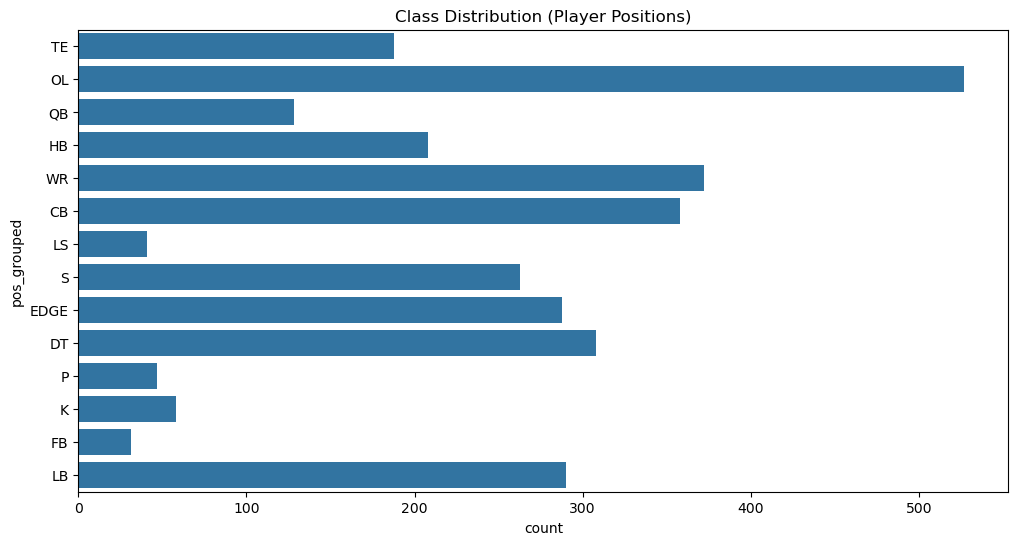

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(y)
plt.title("Class Distribution (Player Positions)")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X.fillna(0), y, test_size=0.2
)

In [12]:
X_train.shape

(2485, 57)

In [13]:
X_test.shape

(622, 57)

In [14]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

Classification Report:
              precision    recall  f1-score   support

          CB       0.90      0.96      0.93        89
          DT       0.94      0.98      0.96        62
        EDGE       0.95      0.90      0.93        62
          FB       1.00      0.43      0.60         7
          HB       1.00      0.94      0.97        34
           K       1.00      0.85      0.92        13
          LB       0.96      0.96      0.96        52
          LS       1.00      0.89      0.94         9
          OL       1.00      1.00      1.00       104
           P       0.82      1.00      0.90         9
          QB       0.96      1.00      0.98        26
           S       0.89      0.79      0.84        42
          TE       0.87      0.94      0.91        36
          WR       0.95      0.99      0.97        77

    accuracy                           0.95       622
   macro avg       0.95      0.90      0.91       622
weighted avg       0.95      0.95      0.94       622



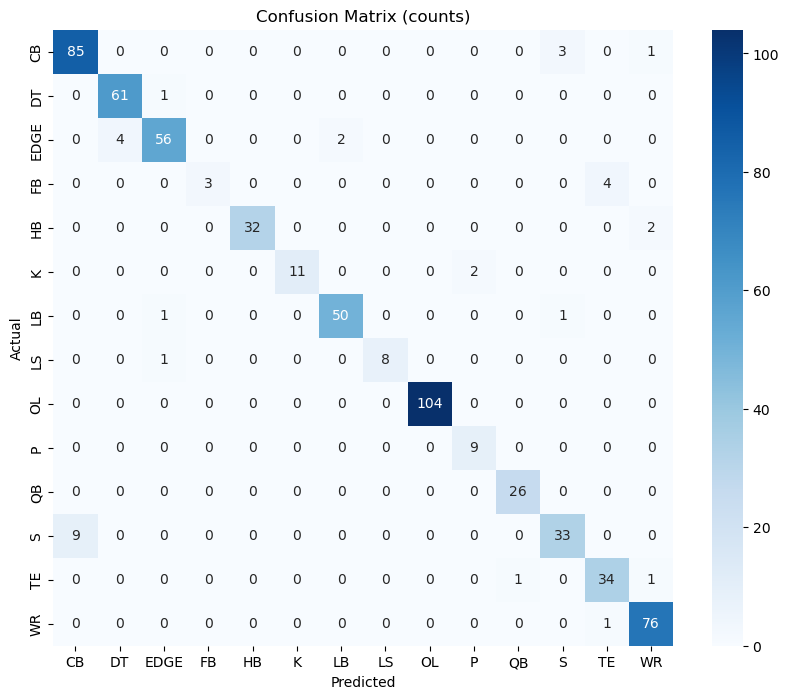

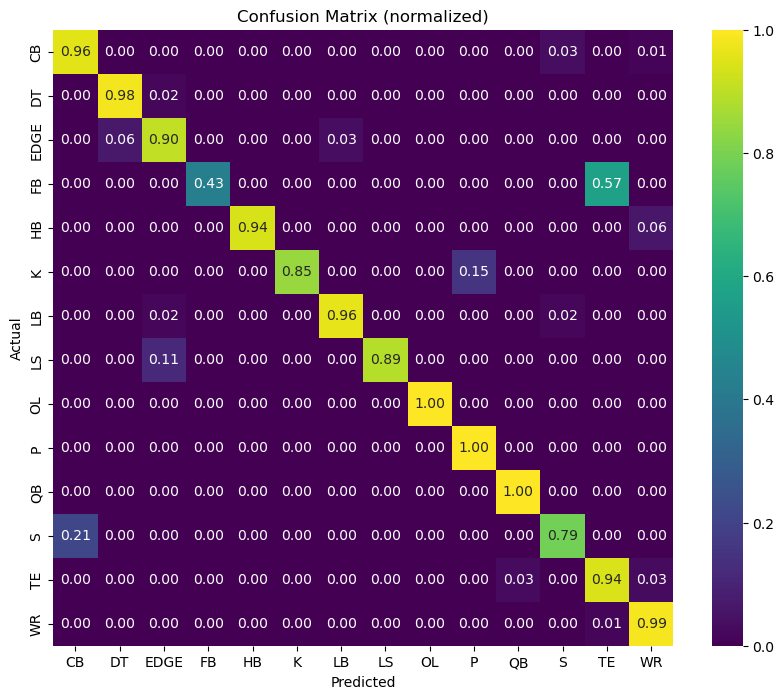

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (counts)')
plt.savefig("/Users/tylerweber/Portfolio/tyler-wbr.github.io/projects/images/confusion_matrix_counts.png", dpi=300, bbox_inches='tight')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (normalized)')
plt.savefig("/Users/tylerweber/Portfolio/tyler-wbr.github.io/projects/images/confusion_matrix_normalized.png", dpi=300, bbox_inches='tight')

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=clf.classes_))


In [16]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro')
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring)

print("Cross-val accuracy: {:.3f} ± {:.3f}".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
print("Cross-val macro-F1: {:.3f} ± {:.3f}".format(cv_results['test_f1_macro'].mean(), cv_results['test_f1_macro'].std()))


Cross-val accuracy: 0.947 ± 0.004
Cross-val macro-F1: 0.919 ± 0.014


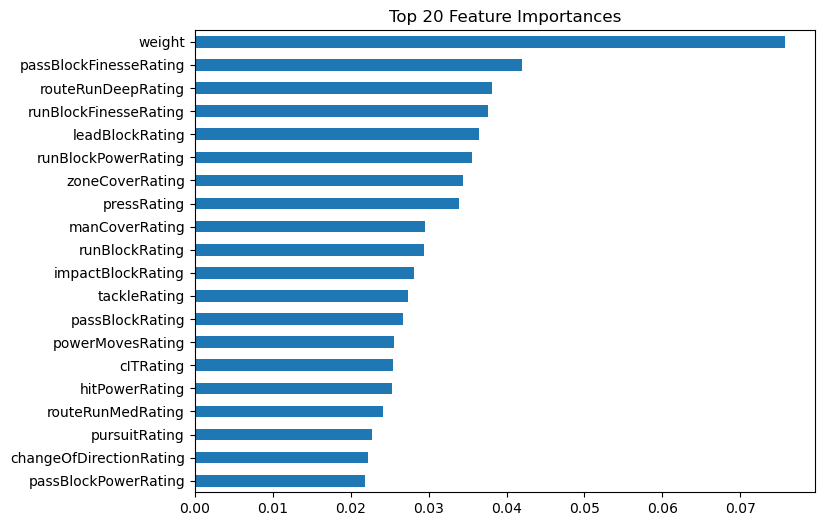

In [17]:
import pandas as pd

feat_names = X.columns if hasattr(X, "columns") else [f"f{i}" for i in range(X.shape[1])]
importances = clf.feature_importances_
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)

fi.plot(kind='barh', figsize=(8,6), title='Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.savefig("/Users/tylerweber/Portfolio/tyler-wbr.github.io/projects/images/feature_importances.png", dpi=300, bbox_inches='tight')
